# Projet BAYES

In [1]:
import numpy as np
from scipy.special import binom
from scipy.stats import norm
import matplotlib.pyplot as plt

### Importation des données

Fichier de données originelles : 
```{r}
N <-
12
t <-
c(11, 11, 17, 22, 9, 6, 5, 14, 9, 7, 22, 51)
x <-
c(6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51)
y <-
c(5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0)
```

In [2]:
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])
t = x + y
data = np.array((x, y, t)).T
data = np.array([tuple(t.tolist()) for t in data[:, :]], dtype=[("x", "<i4"), ("y", "<i4"), ("t", "<i4")])
data

array([( 6,  5, 11), ( 9,  2, 11), (17,  0, 17), (22,  0, 22),
       ( 7,  2,  9), ( 5,  1,  6), ( 5,  0,  5), (14,  0, 14),
       ( 9,  0,  9), ( 7,  0,  7), ( 9, 13, 22), (51,  0, 51)],
      dtype=[('x', '<i4'), ('y', '<i4'), ('t', '<i4')])

## Sans variable latentes

### Lois conditionelles

In [3]:
sigma2 = 1

In [4]:
def logit(x):
    return np.log(x / (1-x))

def log_dens_p(p, data, theta):
    y, x, t = data["y"], data["x"], data["t"]
    # densité de p
    lp = -logit(p)**2 / (2 * sigma2) - np.log(p) -  np.log(1-p)
    # masse pour y_i == 0
    ly0 = np.sum(np.log(theta + (1-theta)*(1-p)**t[y==0]))
    # loi pour y_i >= 1
    lyg1 = np.sum(np.log(1-theta) + np.log(binom(t[y>=1], y[y>=1])) + y[y>=1] * np.log(p) + (t[y>=1]-y[y>=1])*np.log(1-p))
    return lp + ly0 + lyg1

def log_dens_theta(theta, data, p):
    y, x, t = data["y"], data["x"], data["t"]
    # densité de theta
    lt = -logit(theta)**2 / (2 * sigma2) - np.log(theta) - np.log(1-theta)
    # masse pour y_i == 0
    ly0 = np.sum(np.log(theta + (1-theta)*(1-p)**t[y==0]))
    # masse pour y_i >= 1
    lyg1 = np.sum(np.log(1-theta) + np.log(binom(t[y>=1], y[y>=1])) + y[y>=1] * np.log(p) + (t[y>=1]-y[y>=1])*np.log(1-p))
    return lt + ly0 + lyg1

### Sampler

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gibbs_hearts(nchain, data, init=None, std_dev=1, burning=0, stride=1):
    chain = np.zeros((burning+nchain, 2))
    acc_rate = np.zeros(2)
    if init is None:
        chain[0] = np.zeros(2)
    else:
        chain[0] = init

    for idx in range(1, burning + nchain):
        # Mise à jour de p
        X = np.copy(chain[idx-1])
        p = sigmoid(X[0])
        alpha_prop = norm.rvs(loc=X[0], scale=std_dev)
        p_prop = sigmoid(alpha_prop)
        acc = np.exp(log_dens_p(p_prop, data, sigmoid(X[1])) - log_dens_p(p, data, sigmoid(X[1])))

        u = np.random.uniform()
        if u <= acc:
            X[0] = alpha_prop
            if idx >= burning:
                acc_rate[0] += 1

        theta = sigmoid(X[1])
        delta_prop = norm.rvs(loc=X[1], scale=std_dev)
        theta_prop = sigmoid(delta_prop)
        acc = np.exp(log_dens_theta(theta_prop, data, sigmoid(X[0])) - log_dens_theta(theta, data, sigmoid(X[0])))

        u = np.random.uniform()
        if u <= acc:
            X[1] = delta_prop
            if idx >= burning:
                acc_rate[1] += 1
        
        chain[idx] = X

    beta = np.exp(chain[:, 0])
    theta = sigmoid(chain[:, 1])

    chain = np.array((chain[:, 0], beta, chain[:, 1], theta)).T
    chain = np.array([tuple(t.tolist()) for t in chain[:, :]],
                     dtype=[("alpha", "f8"), ("beta", "f8"), ("delta", "f8"), ("theta", "f8")])

    return chain[burning::stride], acc_rate / nchain

chain, acc_rate = gibbs_hearts(10**4, data, burning=1000, std_dev=1)
acc_rate

array([0.314 , 0.5273])

Résultats :
                mean        sd    median
alpha        -0.4638    0.2680   -0.4634
beta          0.6519    0.1783    0.6291
delta         0.2556    0.5665    0.2545
theta         0.5592    0.1298    0.5633



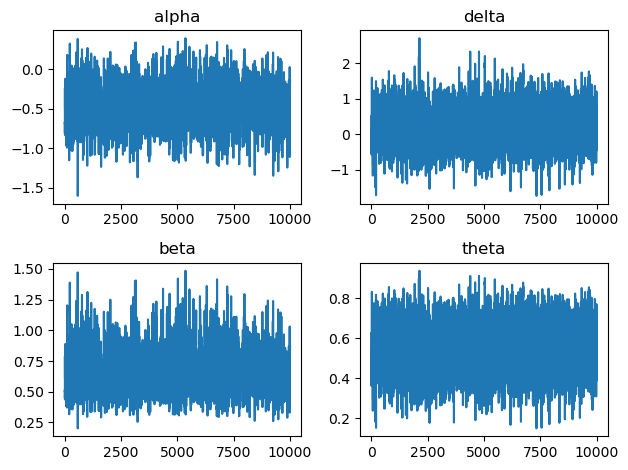

In [6]:
def report(data):
    res = "Résultats :\n"
    res += f"{"":>10}"
    res += f"{"mean":>10}"
    res += f"{"sd":>10}"
    res += f"{"median":>10}\n"
    for name in data.dtype.names:
        res += f"{name:10}"
        res += f"{np.mean(data[name]):10.4f}"
        res += f"{np.sqrt(np.var(data[name])):10.4f}"
        res += f"{np.median(data[name]):10.4f}\n"
    return res

print(report(chain))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(chain["alpha"])
axs[0, 0].set_title("alpha")
axs[1, 0].plot(chain["beta"])
axs[1, 0].set_title("beta")
axs[0, 1].plot(chain["delta"])
axs[0, 1].set_title("delta")
axs[1, 1].plot(chain["theta"])
axs[1, 1].set_title("theta")
fig.tight_layout()

## Avec variables latentes

In [7]:
def log_dens_p_latent(p, data, latent):
    y, x = data["y"], data["x"]
    # densité de p
    lp = -logit(p)**2 / (2 * sigma2) - np.log(p) -  np.log(1-p)
    # masse de y
    py = np.sum(y[latent==0]) * np.log(p) + np.sum(x[latent==0]) * np.log(1-p)
    return lp + py

def log_dens_theta_latent(theta, latent):
    # densité de theta
    lt = -logit(theta)**2 / (2 * sigma2) - np.log(theta) - np.log(1-theta)
    # masse des variables latentes
    cl = np.sum(latent==1)
    pt = cl * np.log(theta) + (len(latent) - cl) * np.log(1 - theta)
    return lt + pt

def log_dens_latent(latent, theta, p, data):
    y, x, t = data["y"], data["x"], data["t"]
    # masse due à y
    py = np.sum(np.log((latent == 1) * (y == 0) + (latent == 0) * (binom(t, y) * p ** y * (1-p)**x)))
    # masse de Z
    cl = np.sum(latent==1)
    pt = cl * np.log(theta) + (len(latent) - cl) * np.log(1 - theta)
    return pt + py

In [8]:
def gibbs_hearts_latent(nchain, data, init=None, std_dev=1, burning=0, stride=1):
    chain = np.zeros((burning+nchain, 2))
    acc_rate = np.zeros(3)
    if init is None:
        chain[0] = np.zeros(2)
    else:
        chain[0] = init
    latent = data["y"] == 0

    for idx in range(1, burning + nchain):
        X = np.copy(chain[idx-1])
        # Mise à jour des variables latentes
        p = sigmoid(X[0])
        theta = sigmoid(X[1])
        idx_prop = np.random.choice(np.nonzero(y == 0)[0])
        l = np.random.binomial(1, theta)
        latent_prop = np.copy(latent)
        latent_prop[idx_prop] = l
        kernel_ratio = (1 - theta + latent[idx_prop] * (2 * theta - 1)) / (1 - theta + latent_prop[idx_prop] * (2 * theta - 1))
        acc = np.exp(log_dens_latent(latent_prop, theta, p, data) - log_dens_latent(latent, theta, p, data)) * kernel_ratio
        u = np.random.uniform()
        if u <= acc:
            latent = np.copy(latent_prop)
            if idx >= burning:
                acc_rate[2] += 1
        
        # Mise à jour de p
        p = sigmoid(X[0])
        alpha_prop = norm.rvs(loc=X[0], scale=std_dev)
        p_prop = sigmoid(alpha_prop)
        acc = np.exp(log_dens_p_latent(p_prop, data, latent) - log_dens_p_latent(p, data, latent))

        u = np.random.uniform()
        if u <= acc:
            X[0] = alpha_prop
            if idx >= burning:
                acc_rate[0] += 1

        theta = sigmoid(X[1])
        delta_prop = norm.rvs(loc=X[1], scale=std_dev)
        theta_prop = sigmoid(delta_prop)
        acc = np.exp(log_dens_theta_latent(theta_prop, latent) - log_dens_theta_latent(theta, latent))

        u = np.random.uniform()
        if u <= acc:
            X[1] = delta_prop
            if idx >= burning:
                acc_rate[1] += 1
        
        chain[idx] = X

    beta = np.exp(chain[:, 0])
    theta = sigmoid(chain[:, 1])

    chain = np.array((chain[:, 0], beta, chain[:, 1], theta)).T
    chain = np.array([tuple(t.tolist()) for t in chain[:, :]], 
                     dtype=[("alpha", "f8"), ("beta", "f8"), ("delta", "f8"), ("theta", "f8")])

    return chain[burning::stride], acc_rate / nchain

chain, acc_rate = gibbs_hearts_latent(10**4, data, burning=1000, std_dev=0.5)
acc_rate

array([0.5124, 0.7245, 0.5763])

Résultats :
                mean        sd    median
alpha        -0.4512    0.2635   -0.4507
beta          0.6593    0.1759    0.6372
delta         0.2531    0.5672    0.2636
theta         0.5588    0.1305    0.5655



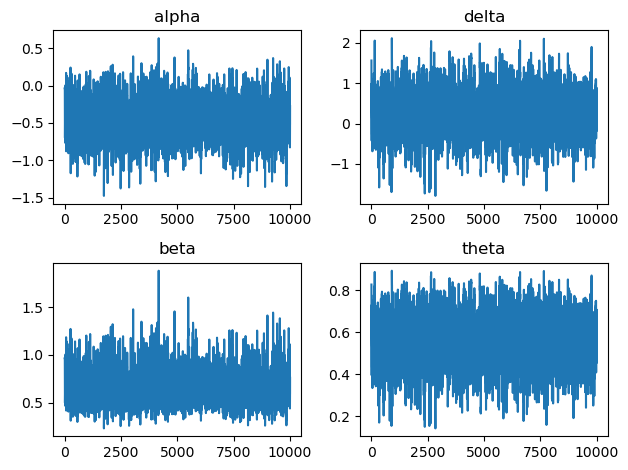

In [9]:
print(report(chain))
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(chain["alpha"])
axs[0, 0].set_title("alpha")
axs[1, 0].plot(chain["beta"])
axs[1, 0].set_title("beta")
axs[0, 1].plot(chain["delta"])
axs[0, 1].set_title("delta")
axs[1, 1].plot(chain["theta"])
axs[1, 1].set_title("theta")
fig.tight_layout()